In [1]:
import bs4
from selenium import webdriver
import requests
import unidecode
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import authentication
import praw
from psaw import PushshiftAPI
import datetime as dt
import json
import sys
import os
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import svm
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import ttest_ind
from scipy.stats import levene

%matplotlib inline
plt.style.use('fivethirtyeight')
tqdm.pandas()



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
df = pd.read_csv('complete_final_dataframe_042820.csv')
df.head()

,created_utc,id,title,date,username,url,author_flair,field,score,gilded,upvote_ratio,no_gilds_for_user,post_gilded,degree,length_of_title_words,length_of_title_char,average_word_length,time_of_day_PST,day_of_the_week,num_comments
0,1420185590,2r31gh,"A skull found in Montana, US belongs to the ea...",2015-01-01 23:59:50,presaging,http://www.bbc.com/earth/story/20141210-first-...,NaN,Paleontology,559,NaN,0,NaN,False,NaN,17.0,99.0,5.8,23,3,16
1,1420184689,2r30hu,Schreiner Medipharm - Development Partner to P...,2015-01-01 23:44:49,David07z,http://www.packagingconnections.com/schreiner/,NaN,NaN,0,NaN,0,NaN,False,NaN,8.0,62.0,7.8,23,3,0
2,1420184568,2r30bm,Omron image sensors designed to be 'eyes' of IoT,2015-01-01 23:42:48,mystypristy,http://www.pcworld.com/article/2824392/omron-i...,NaN,NaN,1,NaN,1,NaN,False,NaN,9.0,48.0,5.3,23,3,0
3,1420183466,2r2z1w,X-Post from r/worldnews. Most cancer is caused...,2015-01-01 23:24:26,swill128,http://www.theguardian.com/society/2015/jan/01...,NaN,Epidemiology,0,[Comment(id='fo0d2i1')],0,1.0,False,NaN,15.0,83.0,5.5,23,3,5
4,1420183433,2r2z0p,Upcoming google project Space elevator must re...,2015-01-01 23:23:53,babubro,https://www.trendcrackers.com/space-elevator-o...,NaN,Engineering,1,NaN,1,NaN,False,NaN,9.0,58.0,6.4,23,3,0


## <span style='color:red'> Which fields are most popular? Let's look at the fields that get the highest score/submission</span>

In [3]:
df.field.replace({'Social Sciences': 'Social Science'}, inplace=True)

In [6]:
# How many posts actually have an field specified? 
df.field.isna().value_counts()

False    151540
True     104513
Name: field, dtype: int64

In [9]:
# Most posts that score highly have a field specified

print('Posts that score > 100 with no field specified:', df[(df.field.isna()==True) & (df.score > 100)].shape[0])
print('Posts that score > 100 with field specified:', df[(df.field.isna()==False) & (df.score > 100)].shape[0])

Posts that score > 100 with no field specified: 206
Posts that score > 100 with field specified: 20910


In [6]:
# How many distinct fields are there?
len(set(df.field))

816

In [18]:
# Let's see which fields get the highest score / submission 
# This gets the summed scores per field

scores = df.groupby('field').sum()[['score']].reset_index()


# We need to figure out how many posts there are for each of these fields
posts_per_field = df.groupby('field').count()[['id']].reset_index()

In [20]:
score_per_submission = scores.merge(posts_per_field, on='field', how='left')
score_per_submission.rename(columns={'id':'number_of_posts'}, inplace=True)
score_per_submission.head()

,field,score,number_of_posts
0,(PDF) Earth Science,360,1
1,/r/science @ SXSW,2473,1
2,3-D Printing AMA,791,1
3,3D Printing AMA,3333,1
4,ACS AMA,2771,5


In [21]:
score_per_submission['score_per_post'] = score_per_submission.score/score_per_submission.number_of_posts
score_per_submission.sort_values('score_per_post', ascending=False).head(10)

,field,score,number_of_posts,score_per_post
599,Psychology - Author in Comments,53329,1,53329.00
715,Subreddit Discussion,203736,5,40747.20
443,Medicine - Misleading,34749,1,34749.00
472,NASA News,33138,1,33138.00
133,Cellular Agriculture AMA,25997,1,25997.00
708,Stephen Hawking AMA,20681,1,20681.00
48,Artificial Intelligence AMA,79499,4,19874.75
492,Net Neutrality,18118,1,18118.00
617,Record Data on DNA AMA,17578,1,17578.00
115,CRISPR Babies Discussion,15254,1,15254.00


#### Interestingly, the fields that get the highest score per post are those that have very few posts, e.g. AMAs etc. 
#### What does the distribution of no of posts/field look like? 


In [22]:
score_per_submission.number_of_posts.value_counts().head()

1    636
2     83
3     28
4     11
5     10
Name: number_of_posts, dtype: int64

(array([  0., 636.,  83.,  28.,  11.,  10.,   1.,   6.,   4.,   4.,   1.,
          0.,   2.,   1.,   1.,   2.,   1.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]),
 <a list of 50 Patch objects>)

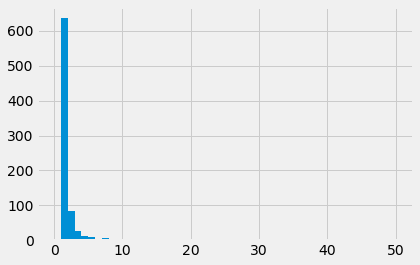

In [43]:
plt.hist(score_per_submission.number_of_posts, 50, (0,50))

### More than 600 of those fields only have one post! 
### Let's remove the fields that have fewer than 50 posts

In [23]:
score_per_submission = score_per_submission[score_per_submission.number_of_posts > 50]
score_per_submission.shape

(22, 4)

### Only 22 of the 800 distinct fields have more than 50 posts.

In [24]:
score_per_submission = score_per_submission.sort_values('score_per_post', ascending=False).reset_index(drop=True)
score_per_submission

,field,score,number_of_posts,score_per_post
0,Psychology,22115584,10649,2076.775660
1,Economics,866131,436,1986.538991
2,Social Science,9831960,7636,1287.579885
3,Epidemiology,2301753,2272,1013.095511
4,Health,18860514,19194,982.625508
5,Neuroscience,7028902,8646,812.965765
6,Environment,9807690,12380,792.220517
7,Medicine,9485302,12701,746.815369
8,Anthropology,2194458,3126,702.001919
9,Cancer,2498177,3764,663.702710


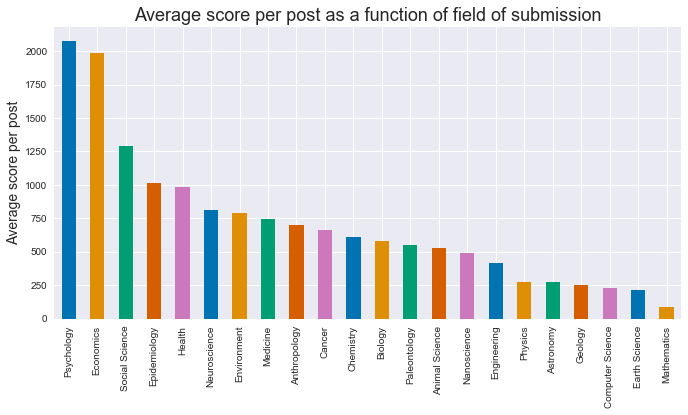

In [279]:
colors = sns.color_palette("colorblind", 5)
ax = score_per_submission[['field', 'score_per_post']].rename({'score_per_post':'Average score per post'},
                                                              axis=1).\
   set_index('field').plot(y='Average score per post', kind='bar', color=colors, figsize=(10,5))
ax.set_xlabel('',fontsize=1)
ax.set_ylabel('Average score per post',fontsize=14)
ax.set_title('Average score per post as a function of field of submission', fontsize=18)
ax.get_legend().remove()
fig = ax.get_figure()
fig.savefig('field.jpg',bbox_inches='tight',dpi=500)

### Unsurpringly, the fields that score the highest (when the number of posts is factored in) are fields that people can relate to more: psychology, economics, social science, and epidemiology.
### Those that don't score as highly are those the general reddit population likely doesn't relate to as well, eg. physics/computer science or Mathematics

In [52]:
# Whats the standard deviation on that?


std = df.groupby('field').score.std().reset_index().rename({'score':'standard deviation'}, axis=1)
std.head()

,field,standard deviation
0,(PDF) Earth Science,NaN
1,/r/science @ SXSW,NaN
2,3-D Printing AMA,NaN
3,3D Printing AMA,NaN
4,ACS AMA,471.896917


In [53]:
score_per_submission.merge(std, on=['field'], how='left')

,field,score,number_of_posts,score_per_post,standard deviation
0,Psychology,22115584,10649,2076.775660,8340.423692
1,Economics,866131,436,1986.538991,8303.504700
2,Social Science,9831960,7636,1287.579885,6855.530572
3,Epidemiology,2301753,2272,1013.095511,5832.853056
4,Health,18860514,19194,982.625508,5615.894602
5,Neuroscience,7028902,8646,812.965765,4693.017983
6,Environment,9807690,12380,792.220517,4766.919982
7,Medicine,9485302,12701,746.815369,4664.498949
8,Anthropology,2194458,3126,702.001919,4327.339112
9,Cancer,2498177,3764,663.702710,4643.024072


### Enormous standard deviation, as expected from the data

#### Sidenote: Epidemiology posts recently

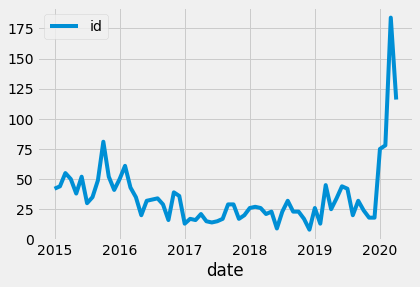

In [157]:
df.date = pd.to_datetime(df.date)
df[(df.field == 'Epidemiology')].set_index('date').groupby(pd.Grouper(freq='m')).count().plot(y='id')

#### There has ben an uptick in the number of epidemiology posts over the last few months, understandably

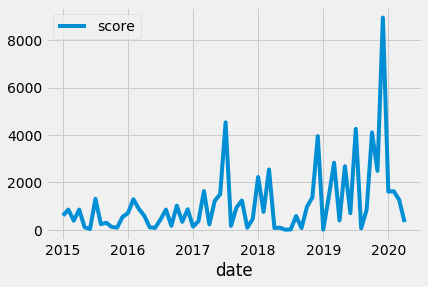

In [151]:
df.date = pd.to_datetime(df.date)
df[df.field == 'Epidemiology'].set_index('date').groupby(pd.Grouper(freq='m')).mean().plot(y='score')

#### However, these haven't been scoring much better on average, and this is most likely due to the fact that there isn't a ton of peer-reviewed research on it (a requirement of the subreddit)

##  <span style='color:red'> Is the level of educational attainment of the author linked to higher scores? </span>


In [204]:
# Approximately 11,000 posts were made by people who disclosed their degree 
df[df.degree.isna()==False].shape

(11298, 20)

In [218]:
degree_df = df[['score','degree']].copy()
degree_df.degree = degree_df.degree.astype('str')
plot_df_degree = degree_df.groupby('degree').agg(['median','mean', 'std'])
plot_df_degree

score                            
          median          mean           std
degree                                      
Bachelors     15    784.482143   4149.172569
Master        20    756.117383   4086.537199
PhD           16   1203.244779   6064.226021
Professor    796  10558.095281  17367.066686
nan            1    302.937668   2903.232371

In [206]:
degree_df.degree.value_counts()

nan          244755
PhD            4788
Professor      3327
Bachelors      1624
Master         1559
Name: degree, dtype: int64

#### We can test to see if there are significant differences between these groups

In [214]:
print(levene(degree_df[degree_df.degree=='Bachelors'].score, \
                degree_df[degree_df.degree=='Master'].score))

print(ttest_ind(degree_df[degree_df.degree=='Bachelors'].score, \
                degree_df[degree_df.degree=='Master'].score, equal_var=True))

LeveneResult(statistic=0.04541078201882698, pvalue=0.8312641353067889)
Ttest_indResult(statistic=0.19423423867706016, pvalue=0.8460048774385278)


In [215]:
print(levene(degree_df[degree_df.degree=='PhD'].score, \
                degree_df[degree_df.degree=='Master'].score))

print(ttest_ind(degree_df[degree_df.degree=='PhD'].score, \
                degree_df[degree_df.degree=='Master'].score, equal_var=False))

LeveneResult(statistic=7.502286161676683, pvalue=0.006179281365648063)
Ttest_indResult(statistic=3.2969403470743877, pvalue=0.0009861183543934458)


In [216]:
print(levene(degree_df[degree_df.degree=='PhD'].score, \
                degree_df[degree_df.degree=='Bachelors'].score))

print(ttest_ind(degree_df[degree_df.degree=='PhD'].score, \
                degree_df[degree_df.degree=='Bachelors'].score, equal_var=False))

LeveneResult(statistic=6.7092782578803485, pvalue=0.009612964420758385)
Ttest_indResult(statistic=3.0971580945706134, pvalue=0.0019670744149066534)


In [217]:
print(levene(degree_df[degree_df.degree=='PhD'].score, \
                degree_df[degree_df.degree=='Professor'].score))

print(ttest_ind(degree_df[degree_df.degree=='PhD'].score, \
                degree_df[degree_df.degree=='Professor'].score, equal_var=False))

LeveneResult(statistic=1180.8242042190072, pvalue=1.0205416290168849e-241)
Ttest_indResult(statistic=-29.831668551365556, pvalue=2.7007419426871553e-176)


### It appears that there is no statistical difference in the score of a post whose author has a BS or MS degree. 
### However, there is a statistical difference in the score of posts where the author has a graduate degree, or is a professor. 
### The trend seems to indicate that the higher the level of educational attainment of the author, the higher, on average, the score of the post.

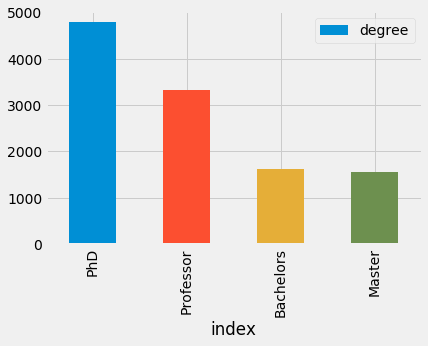

In [146]:
# What's the distribution of posts made by people with various degrees? 
degree_df[degree_df.degree != 'nan'].degree.value_counts().reset_index().plot(kind='bar', x='index', y='degree')

In [ ]:
fig = plt.figure()

ax = df[df.score>10].time_of_day_PST.value_counts().sort_index().plot(kind='bar', color=colors)
ax.set_xlabel('Time of day', fontsize=14)
ax.set_ylabel('Number of posts', fontsize=14)
ax.set_title('Posts with score > 10', fontsize=18, fontweight=700)
ax.get_figure()
fig.savefig('posts10.jpg',bbox_inches='tight',dpi=500)

<Figure size 576x396 with 0 Axes>

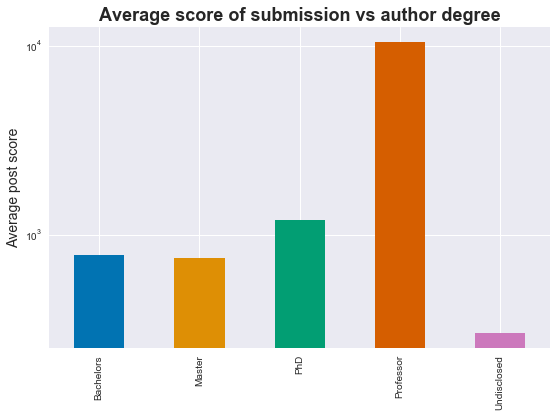

In [271]:
colors = sns.color_palette("colorblind", 5)
fig = plt.figure()

ax = degree_df.groupby('degree').mean().reset_index().replace({'nan':'Undisclosed'}).\
                            plot(x='degree', y='score', kind='bar', color=colors)
ax.set_xlabel('', fontsize=1)
ax.set_ylabel('Average post score', fontsize=14)
ax.set_title('Average score of submission vs author degree', fontsize=18, fontweight=700)
ax.set_yscale('log')
ax.get_legend().remove()

fig = ax.get_figure()
fig.savefig('degree_type.jpg', bbox_inches='tight', dpi=500)

## <span style='color:red'> Does daily time of posting have an influence on score? </span>

In [188]:
colors = sns.color_palette("colorblind", 4)
mpl.style.use('seaborn')


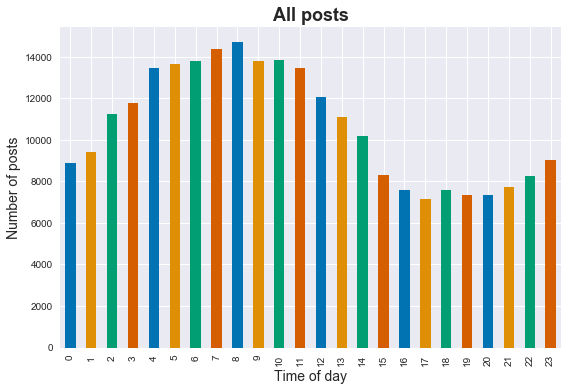

In [199]:
fig = plt.figure()
ax = df.time_of_day_PST.value_counts().sort_index().plot(kind='bar', color=colors)
ax.set_xlabel('Time of day', fontsize=14)
ax.set_ylabel('Number of posts', fontsize=14)
ax.set_title('All posts', fontsize=18, fontweight=700)

ax.get_figure()
fig.savefig('posts.jpg',bbox_inches='tight',dpi=500)

### More posts around 8am, i.e. when East Coast, West Coast and Europe are all awake.

### What does this picture look like for posts that score more highly? 

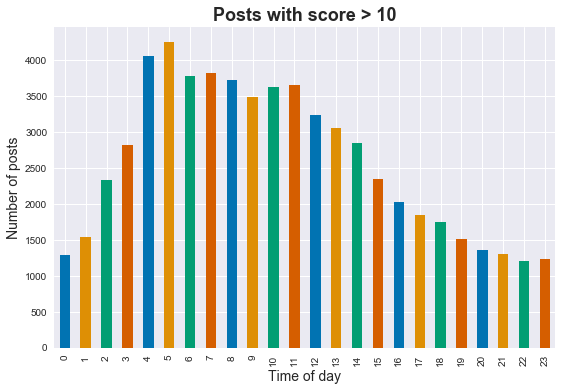

In [203]:
fig = plt.figure()

ax = df[df.score>10].time_of_day_PST.value_counts().sort_index().plot(kind='bar', color=colors)
ax.set_xlabel('Time of day', fontsize=14)
ax.set_ylabel('Number of posts', fontsize=14)
ax.set_title('Posts with score > 10', fontsize=18, fontweight=700)
ax.get_figure()
fig.savefig('posts10.jpg',bbox_inches='tight',dpi=500)

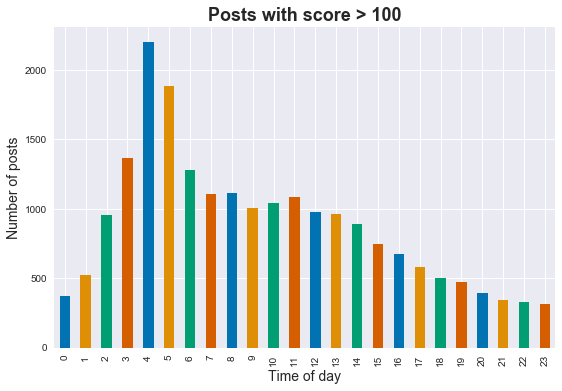

In [200]:
fig = plt.figure()

ax = df[df.score>100].time_of_day_PST.value_counts().sort_index().plot(kind='bar', color=colors)
ax.set_xlabel('Time of day', fontsize=14)
ax.set_ylabel('Number of posts', fontsize=14)
ax.set_title('Posts with score > 100', fontsize=18, fontweight=700)
ax.get_figure()
fig.savefig('posts100.jpg',bbox_inches='tight',dpi=500)

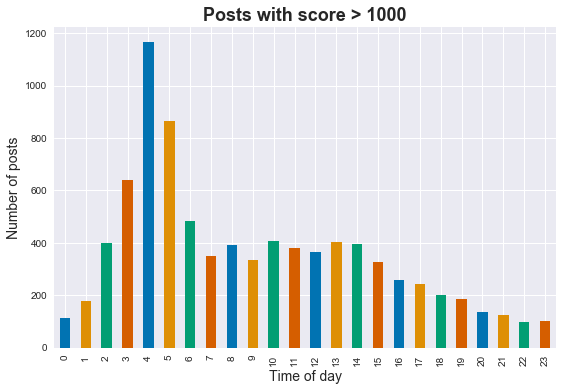

In [201]:
fig = plt.figure()


ax = df[df.score>1000].time_of_day_PST.value_counts().sort_index().plot(kind='bar', color=colors)
ax.set_xlabel('Time of day', fontsize=14)
ax.set_ylabel('Number of posts', fontsize=14)
ax.set_title('Posts with score > 1000', fontsize=18, fontweight=700)
ax.get_figure()
fig.savefig('posts1000.jpg',bbox_inches='tight',dpi=500)

### You want to be posting around 4am PST time in order to score highly, i.e. when Europe is having lunch (+8 hours) and when the East Coast is waking up/going to work (+4 hours)¶
### This makes sense, given the importance of the timing of upvotes in the Reddit sorting algorithm

### Let's see what this looks like when plotting median score as a function of time of day

In [194]:
# Have to remove posts that have a score of 1, otherwise median is flat

time_of_day_df = df[df.score > 1][['score', 'time_of_day_PST']].groupby('time_of_day_PST').\
                                                  median().reset_index()

time_of_day_df.rename(columns={'score': 'median_score'}, inplace=True)

In [213]:
time_of_day_df['p2_quantile'] = df[df.score > 1][['score', 'time_of_day_PST']].groupby('time_of_day_PST')\
                                                                                .quantile(0.2).values
time_of_day_df['p8_quantile'] = df[df.score > 1][['score', 'time_of_day_PST']].groupby('time_of_day_PST')\
                                                                                .quantile(0.8).values

In [219]:
time_of_day_df.head(10)

,time_of_day_PST,median_score,p2_quantile,p8_quantile
0,0,14,4.0,70.0
1,1,17,4.0,105.0
2,2,22,4.0,202.0
3,3,26,5.0,420.2
4,4,37,6.0,993.8
5,5,24,5.0,332.0
6,6,16,4.0,99.0
7,7,14,4.0,72.0
8,8,14,4.0,73.0
9,9,14,4.0,70.2


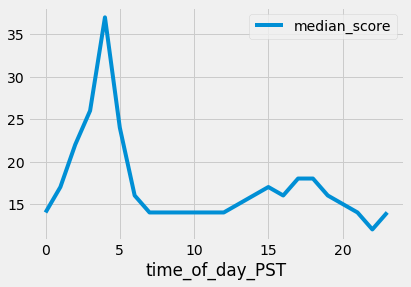

In [176]:
time_of_day_df.plot(kind='line', x='time_of_day_PST', y='median_score')

## P20/P80 values are very spread out, which is a reflection of how large the variability in the data is.

## <span style='color:red'> Relationship between length of post and score </span>

Text(0, 0.5, 'Number of posts')

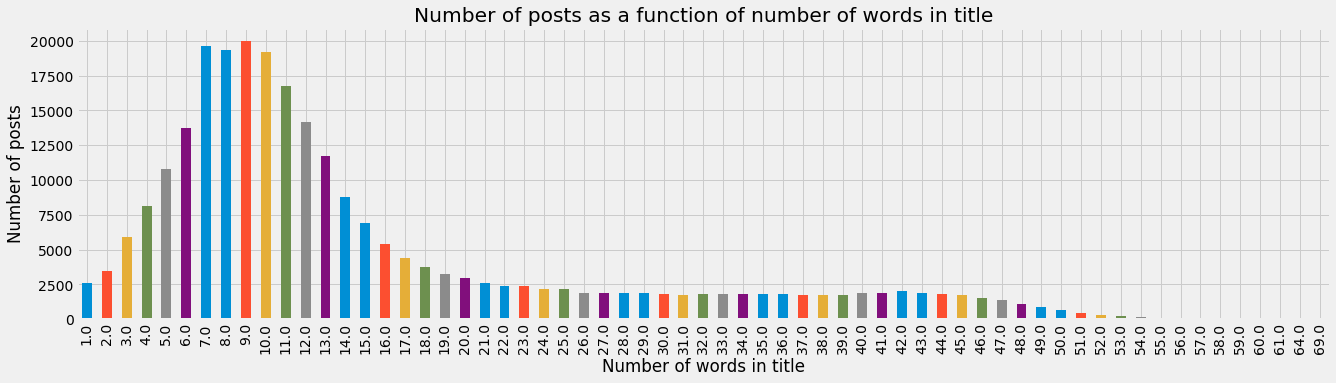

In [147]:
ax = df.length_of_title_words.value_counts().sort_index().plot(kind='bar', figsize=(20,5))

ax.set_title('Number of posts as a function of number of words in title')
ax.set_xlabel('Number of words in title')
ax.set_ylabel('Number of posts')

### Right-skewed, centered around 9 words for the title (fairly short)

### However, as soon as you remove posts that haven't scored very high, a peak at ~ 40 words appear, which becomes more prominent as you look at posts that score more and more highly

Text(0, 0.5, 'Number of posts')

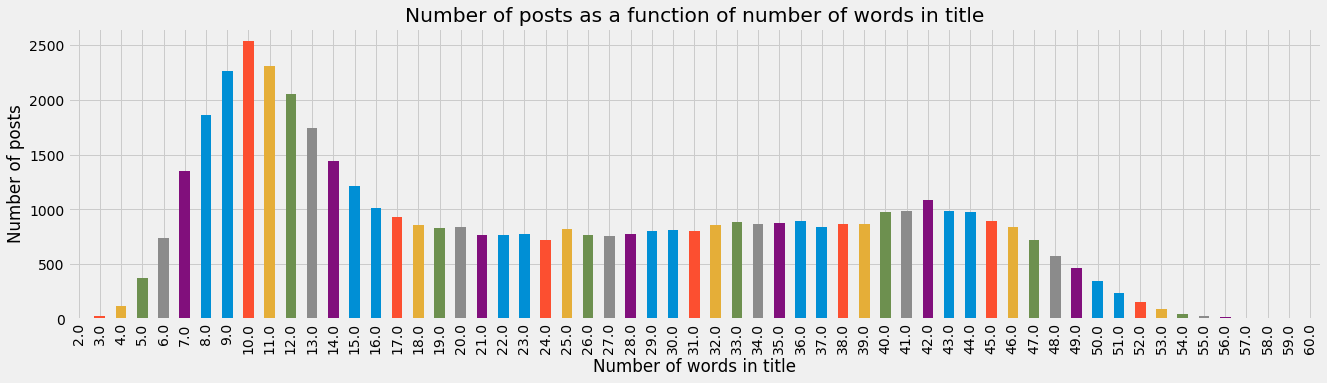

In [220]:
ax = df[df.score>20].length_of_title_words.value_counts().sort_index().plot(kind='bar', figsize=(20,5))

ax.set_title('Number of posts as a function of number of words in title')
ax.set_xlabel('Number of words in title')
ax.set_ylabel('Number of posts')

Text(0, 0.5, 'Number of posts')

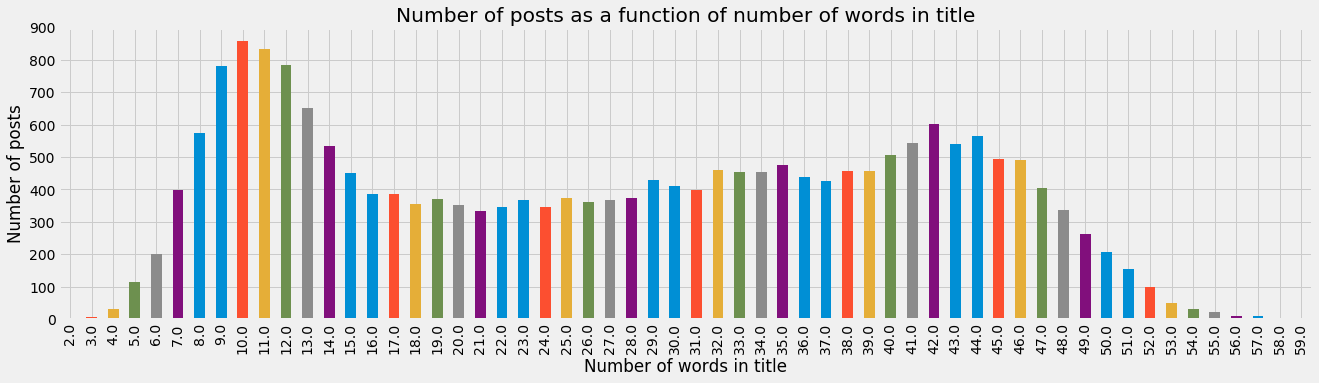

In [222]:
ax = df[df.score>100].length_of_title_words.value_counts().sort_index().plot(kind='bar', figsize=(20,5))

ax.set_title('Number of posts as a function of number of words in title')
ax.set_xlabel('Number of words in title')
ax.set_ylabel('Number of posts')

Text(0.5, 0, 'Number of words in title')

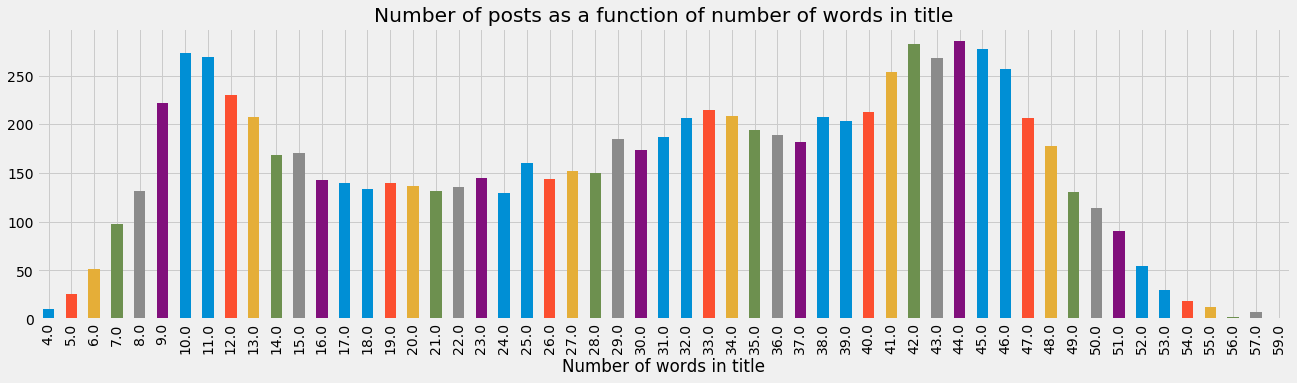

In [223]:
ax = df[df.score>1000].length_of_title_words.value_counts().sort_index().plot(kind='bar', figsize=(20,5))

ax.set_title('Number of posts as a function of number of words in title')
ax.set_xlabel('Number of words in title')

### Important to note that the scale shifts a lot between these plots. This is a reflection of how heavily skewed towards low scores this data is, as illustrated below

Text(0, 0.5, 'Number of posts')

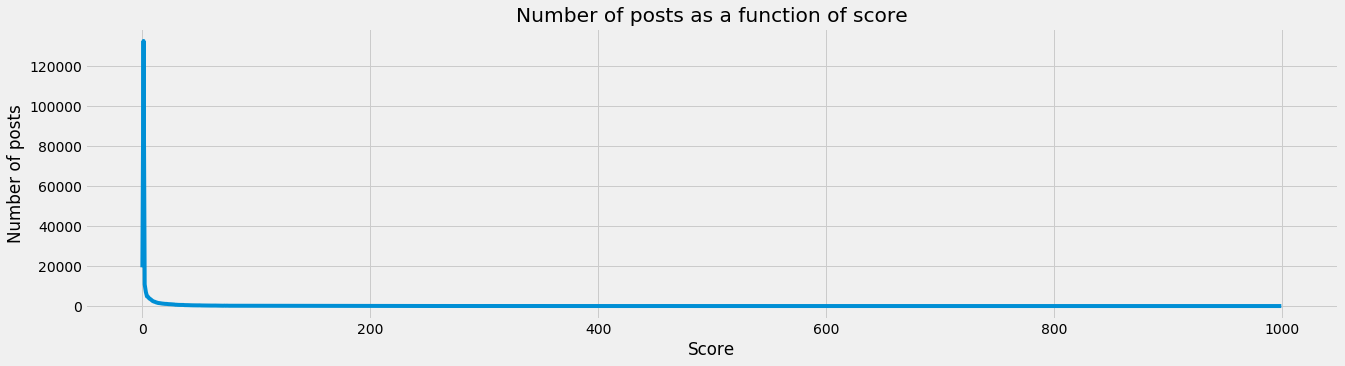

In [228]:
ax = df[df.score < 1000].score.value_counts().sort_index().plot(kind='line', figsize=(20,5), 
                                                           title='Number of posts as a function of score')
ax.set_xlabel('Score')
ax.set_ylabel('Number of posts')

## Look at correlation of length of title with score
### Length of title and score seem to be fairly correlated (spearman corr ~ 0.44)

### Let's replot score as a function of length of title in words, but let's compute the average of those values


In [236]:
# Have to remove posts that have a score of 1, otherwise median is flat

title_length_df = df[df.score > 1][['score', 'length_of_title_words']].groupby('length_of_title_words').\
                                                                       median().reset_index()

title_length_df.rename(columns={'score': 'median_score'}, inplace=True)

In [240]:
title_length_df['p2_quantile'] = df[df.score > 1][['score', 'length_of_title_words']]\
                                .groupby('length_of_title_words').quantile(0.2).values
title_length_df['p8_quantile'] = df[df.score > 1][['score', 'length_of_title_words']]\
                                .groupby('length_of_title_words').quantile(0.8).values
title_length_df.head()

,length_of_title_words,median_score,p2_quantile,p8_quantile
0,1.0,2.0,2.0,3.4
1,2.0,3.0,2.0,6.0
2,3.0,3.0,2.0,9.0
3,4.0,5.0,2.0,16.0
4,5.0,6.0,2.0,24.0


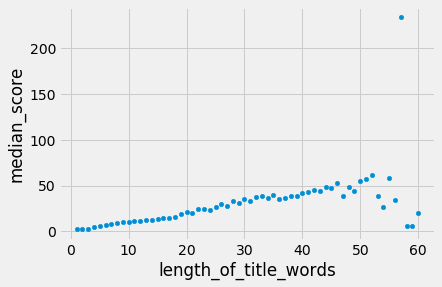

In [238]:
title_length_df.plot(kind='scatter', x='length_of_title_words', y='median_score')

### Linear relationship between the length of title in words and median score of the post
### Rationale: longer posts are more likely to contain the key takeaway information from the study. Users can then relate to it, upvote it, and move on. Posts that are too short require that the user follow up on the reference cited by the post, hence less likely to get upvotes.
### Linear relationship breaks down after ~ 50 words. Most likely because those posts are too long for people to read until the end/get the takeaway without opening the post.
#### Outlier at 57 words, very few posts have this many words, and a few of them have scored very highly

## <span style='color:red'> Trying to predict the score of a post based on the length of its title

In [271]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xstd = ss.fit_transform(df[(df.score > 100) & (df.length_of_title_words.isna()==False)]\
                        [['length_of_title_words']].values)
y = df[(df.score > 100) &(df.length_of_title_words.isna()==False)].score.values
X_train, X_test, y_train, y_test = train_test_split(Xstd,y)
lr = LinearRegression().fit(X_train, y_train)
print('training score: ', lr.score(X_train, y_train))
print('testing score: ', lr.score(X_test,y_test))


training score:  0.03688473912674395
testing score:  0.040015183517702946


In [272]:
X_test.flatten()

array([-1.18546996, -1.11223346,  1.15809819, ...,  1.01162518,
        1.59751721, -0.52634142])

In [273]:
temp = pd.DataFrame(columns=['X_test','y_predict','y_actual'])
temp.X_test = [float(x) for x in X_test.flatten()]
temp.y_predict = lr.predict(X_test)
temp.y_actual = y_test

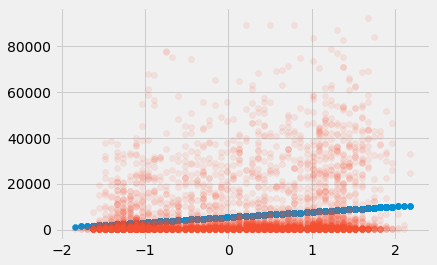

In [277]:
ax = plt.scatter(temp.X_test, temp.y_predict)
plt.scatter(temp.X_test, temp.y_actual, alpha=0.1)

### Predicted (blue) versus actual (red) score of post


## <span style='color:red'> Can we get a rough prediction of users' degree type using a SVM classifier?


In [35]:
# SVM predictive model
from sklearn import svm

classifier_df = df[df.degree.isna()==False].copy()

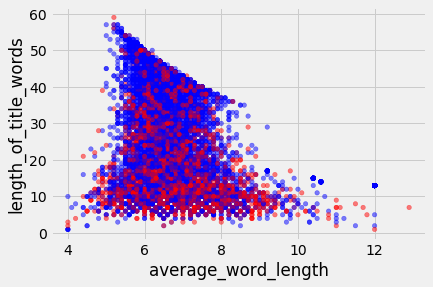

In [36]:
# Let's see how the data is distributed
color_map = {'PhD':'b', 'Professor':'b', 'Bachelors':'r', 'Master': 'r'}
colors = classifier_df.degree.map(color_map)
classifier_df.plot(kind='scatter', x='average_word_length', y='length_of_title_words', 
                  c=colors, alpha=0.5)

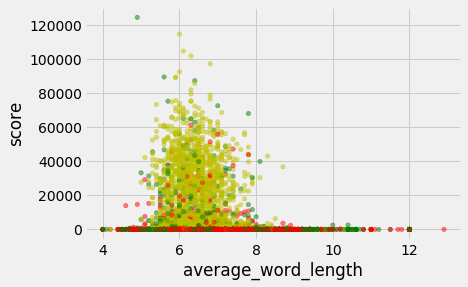

In [37]:
# Let's see how the data is distributed
color_map = {'PhD':'g', 'Professor':'y', 'Bachelors':'r', 'Master': 'r'}
colors = classifier_df.degree.map(color_map)
classifier_df.plot(kind='scatter', x='average_word_length', y='score', 
                  c=colors, alpha=0.5)

In [38]:
X = np.array([classifier_df.score]).reshape(-1,1)
y = np.array(classifier_df.degree)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Now train the model
clf = svm.SVC(gamma='scale')
clf.fit(X_train, y_train)

# And now test it
sum(clf.predict(X_test) == y_test)/len(y_test)

0.5228318584070797

### Score seems to be better than random assignment (which would have a 25% score)

### However, it looks like it's assigning very few masters/bachelors

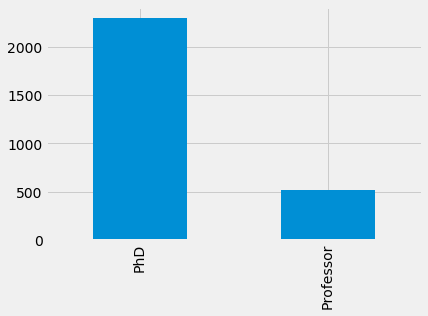

In [39]:
pd.Series(clf.predict(X_test)).value_counts().plot(kind='bar')

### Especially when compared to the original data

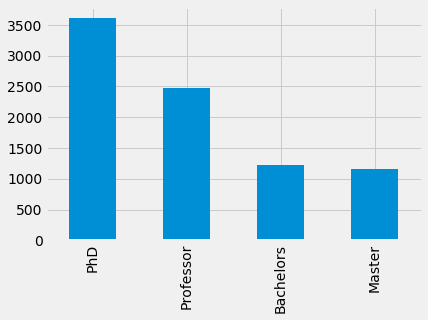

In [40]:
pd.Series(y_train).value_counts().plot(kind='bar')

#### Let's see if we can group PhD+Professor and discrimate against Bachelors/Master

### See if we can get higher accuracy with a two class approach, grouping professors + phd together and master + bachelor together

In [284]:

def is_Phd(row):
    if 'PhD' in row.degree or 'Professor' in row.degree: 
        return 'PhD'
    else:
        return 'Not PhD'
classifier_df['PhD_or_not'] = classifier_df.apply(is_Phd, axis=1)


In [285]:
X = np.array([classifier_df.score]).reshape(-1,1)
y = np.array(classifier_df.PhD_or_not)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Now train the model
clf = svm.SVC(gamma='auto')
clf.fit(X_train, y_train)

# And now test it
sum(clf.predict(X_test) == y_test)/len(y_test)

0.7178761061946902

### Initially this seems to be good, but it's actually no better than if you took the proportion of PhD in your training set and assigned 'PhD' to your testing set, with probability = proportion of PhD

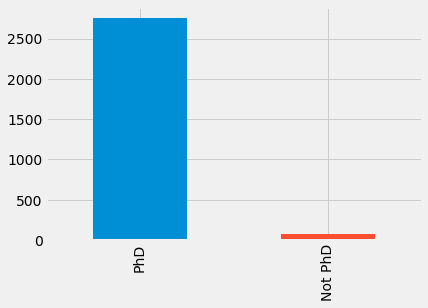

In [286]:
pd.Series(clf.predict(X_test)).value_counts().plot(kind='bar')

In [99]:
classifier_df.PhD_or_not.value_counts()

PhD        8115
Not PhD    3183
Name: PhD_or_not, dtype: int64

## <span style='color:red'> Relationship between average length of word and score of post </span>

In [246]:
high_scoring_posts = df[df.score >= 10000].copy()
medium_scoring_posts = df[(500 <= df.score) & (df.score < 10000)].copy()
low_scoring_posts = df[df.score < 500].copy()



high_scoring_posts.dropna(subset=['average_word_length'], inplace=True)
medium_scoring_posts.dropna(subset=['average_word_length'], inplace=True)
low_scoring_posts.dropna(subset=['average_word_length'], inplace=True)


#### What's the average word length in these 3 groups? 

In [247]:
print('High scoring posts, mean: ', np.average(high_scoring_posts.average_word_length))
print('High scoring posts, standard deviation: ', np.std(high_scoring_posts.average_word_length))

print('Medium scoring posts, mean: ', np.average(medium_scoring_posts.average_word_length))
print('Medium scoring posts, standard deviation: ', np.std(medium_scoring_posts.average_word_length))

print('Low scoring posts, mean: ', np.average(low_scoring_posts.average_word_length))
print('Low scoring posts, standard deviation: ', np.std(low_scoring_posts.average_word_length))

High scoring posts, mean:  6.401865907653384
High scoring posts, standard deviation:  0.6389079350799876
Medium scoring posts, mean:  6.462403639580438
Medium scoring posts, standard deviation:  0.7168641678548311
Low scoring posts, mean:  6.664207484090083
Low scoring posts, standard deviation:  3.281943578722985


In [256]:
from scipy.stats import levene
levene(high_scoring_posts.average_word_length,low_scoring_posts.average_word_length)

LeveneResult(statistic=99.12515987237565, pvalue=2.3944281095883222e-23)

In [245]:
# Are there any significant differences in average word length for these posts? 
# Leven test shows that the distributions have unequal variance
print('medium/low difference:', ttest_ind(medium_scoring_posts.average_word_length,\
                                          low_scoring_posts.average_word_length, equal_var=False))
print('medium/high difference:', ttest_ind(medium_scoring_posts.average_word_length,\
                                           high_scoring_posts.average_word_length, equal_var=False))
print('high/low difference:', ttest_ind(low_scoring_posts.average_word_length,\
                                        high_scoring_posts.average_word_length, equal_var=False))

medium/low difference: Ttest_indResult(statistic=-19.33638565078242, pvalue=1.294607139723659e-82)
medium/high difference: Ttest_indResult(statistic=4.345363119692582, pvalue=1.411673283626923e-05)
high/low difference: Ttest_indResult(statistic=19.939334263411304, pvalue=1.4952302410070585e-85)


### Significant difference in average word length between the low, medium and high scoring groups

In [ ]:
# What does the distribution look like? 

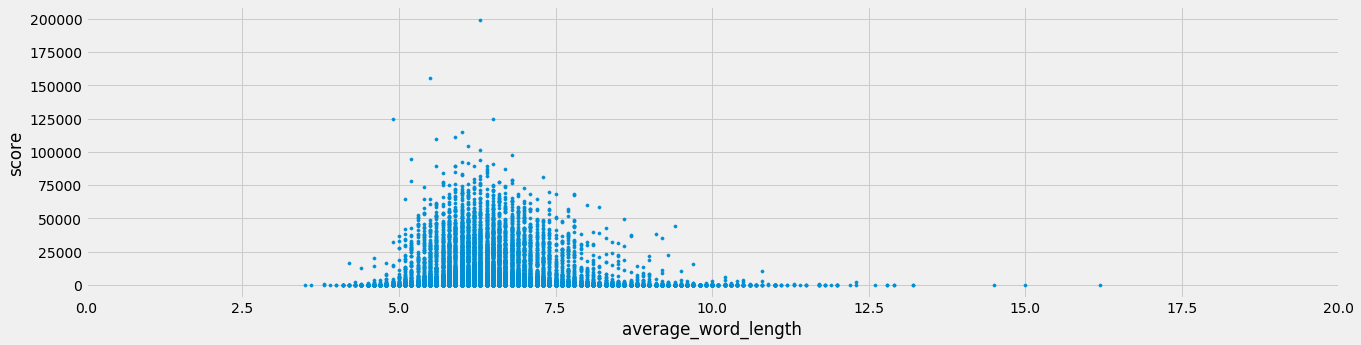

In [48]:
df[df.score>10].plot(kind='scatter',x='average_word_length', y='score', xlim=(0,20), s=10, figsize=(20,5))

### Another way to look at this is to segment the average word length into bins, and see if there are any differences between those bins


In [249]:
df_length_word = df.copy()
df_length_word['average_word_length_bin'] = pd.cut(df_length_word.average_word_length,\
                                              bins=[x for x in np.arange(0,20,5)]).astype('str')

#### Is there a statistical significance between those different bins? I.e. a different way of looking at what was done previously
#### Look at score as a function of average word length for posts that have a score > 10

In [250]:
df_length_word[df_length_word.score > 10][['average_word_length_bin', 'score']].\
                                            groupby('average_word_length_bin').agg(['mean', 'std'])

score             
                                mean          std
average_word_length_bin                          
(0, 5]                    701.530337  5066.519097
(10, 15]                  270.248485  1050.829077
(5, 10]                  1906.788702  7518.026106
nan                        11.000000          NaN

In [251]:
short_words = df_length_word[(df_length_word.score > 10) & (df_length_word.average_word_length_bin == '(0, 5]')].\
                dropna(subset=['average_word_length_bin', 'score']).score
medium_words = df_length_word[(df_length_word.score > 10) & (df_length_word.average_word_length_bin == '(5, 10]')].\
                dropna(subset=['average_word_length_bin', 'score']).score
long_words = df_length_word[(df_length_word.score > 10) & (df_length_word.average_word_length_bin == '(10, 15]')].\
                dropna(subset=['average_word_length_bin', 'score']).score

In [266]:
print(levene(short_words, medium_words))
print(levene(medium_words, long_words))
print(levene(short_words, long_words))

LeveneResult(statistic=22.609538072622627, pvalue=1.9894203273370455e-06)
LeveneResult(statistic=7.755744878939244, pvalue=0.005355838914040865)
LeveneResult(statistic=1.1651865424829744, pvalue=0.2806396721186481)


In [269]:
print(ttest_ind(short_words, medium_words, equal_var=False))
print(ttest_ind(medium_words, long_words, equal_var=False))
print(ttest_ind(short_words, long_words, equal_var=True))

Ttest_indResult(statistic=-6.985686456052002, pvalue=5.337414214816576e-12)
Ttest_indResult(statistic=18.750713018707803, pvalue=6.204760862595439e-47)
Ttest_indResult(statistic=1.0887022749733766, pvalue=0.27653430157568076)


### A post with an average word length that is longer than 10 characters or shorter than 5 characters is less likely to score as highly as a post with an average word length between 5 and 10 characters

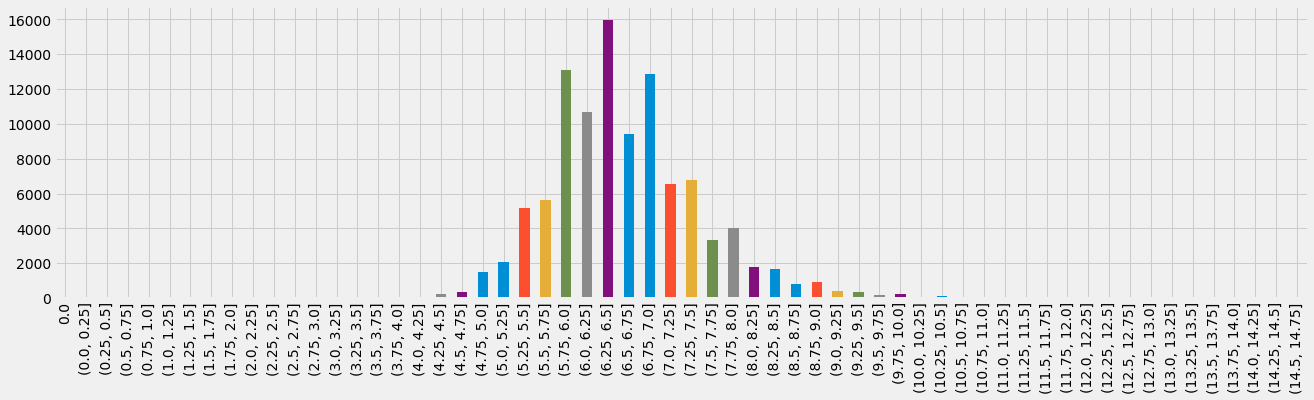

In [68]:
# Can look at the distribution of average word length with smaller bins
bins = [x for x in np.arange(0,15,0.25)]
for_plotting = pd.cut(df_length_word[df_length_word.score >= 2].average_word_length,\
                      bins).value_counts()
for_plotting.reindex(bins).plot(kind='bar', figsize=(20,5))
